### Appendix
- Click on the links:

>1.   <a href=#intro>Introduction</a>
>2.   <a href=#imports>Impotrt library</a>
>3.   <a href=#load>Load Data</a>
>4.   <a href=#processing>Data processing</a>
>5.   <a href=#Preparing>Preparing base model</a>
>6.   <a href=#tunning>Model with fine tunning</a>





##   <a name='intro'>1) Introduction:</a>

### Detecting Indications for recovery from coma System with OpenCV and Keras 
   A coma is a condition in which the patient is unable to interact with the surrounding environment, because he is unconscious and his brain activity is low. However, there are indications of recovery from coma that must be taken into account, including:

    1- The patient can speak some words, move the eye and open the eye when hearing the noise.

    2- The patient shows a response to pain, such as opening the eye when feeling pain.

   Hence, With this Python project, we will be making a model detection system. helps to detect if patient opening  eyes, where the doctors give a warning that the patient has opened his eyes
So, to detect this case we will build a system using Python, OpenCV, and Keras which will alert the doctor when patient he opened his eyes.

![](download1.jpg)

##   <a name='imports'>2) Impotrt library:</a>

In [1]:
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
to_categorical = tf.keras.utils.to_categorical

import random,shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import load_model

##   <a name='load'>3) Load Data:</a>

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train= tf.keras.preprocessing.image_dataset_from_directory("train",
    #validation_split=0.2,
    #subset= "training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE

)

## loading testing data
validation = tf.keras.preprocessing.image_dataset_from_directory("val",
    #validation_split=0.2,
    #subset= "validation",
    seed=42,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 1224 files belonging to 2 classes.
Found 248 files belonging to 2 classes.


##   <a name='processing'>4) Data processing:</a>


In this project a classification model will be created in order to classify images of eyes people with closed and open 


In [3]:
class_names = train.class_names
print(class_names)

['Closed', 'Open']


In [4]:
val_batches = tf.data.experimental.cardinality(validation)
test = validation.take(val_batches // 3)
validation = validation.skip(val_batches // 3)

In [5]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test))

Number of training batches: 38
Number of validation batches: 6
Number of test batches: 2


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
validation = validation.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

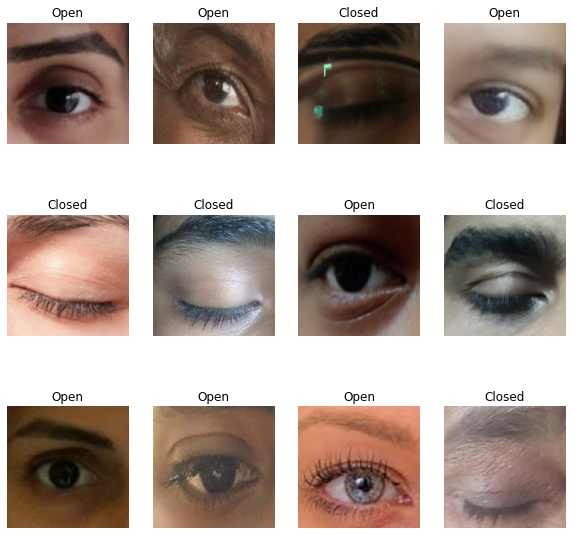

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(3,4 , i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

##   <a name='Preparing'>5) Preparing base model:</a>

### 5.1) Data augmentation:
Data augmentation is an optional step which introduces several artificial observations to the training sample.
In this model we are going to introduce two data augmentations:

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Below we can find the results of the data augmentation:

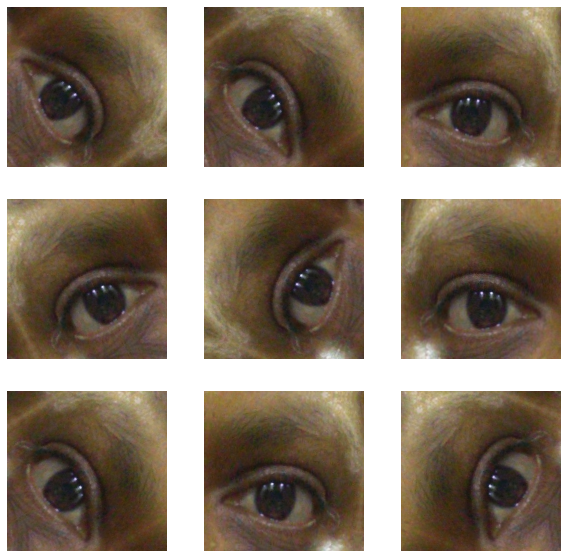

In [9]:
for image, _ in train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### 5.2) Rescale pixel values:
Firstly, the application MobileNetV2 will be downloaded, which is going to be used as a base for the model. This is a way of performing transfer learning, which consists in using a training learning from a pre-trained network

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


Note: each Keras Application expects a specific kind of input preprocessing.</n>

<n>For MobileNetV2, call tf.keras.applications.mobilenet_v2.</n>

<n>preprocess_input on your inputs before passing them to the model. mobilenet_v2.preprocess_input will scale input pixels between -1 and 1.</n>

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

### 5.3) Creating base model from MobileNet V2:


The base model MobileNet V2 was developed by Google It contains a large dataset with 1.4 million of images and 1000 classes


It is important to include include_top=False because the classification layers previously created should be included

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### This feature extractor converts the images from 160x160x3 to 5x5x1280


In [13]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### 5.4) Feature extraction:

First of all, we should freeze the convolutional base created from the previous step, because it is going to be used as a feature extractor


In [14]:
base_model.trainable = False

### 5.5) Adding classification head:


The layer tf.keras.layers.GlobalAveragePooling2D is going to be used, 

in order to convert the features in a 1280-element vector, per each image.


In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### 5.6) Compilation of the model:


In [18]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\hp\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 5.7) Training the model:


In [20]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation)

6/6 [==============================] - 5s 310ms/step - loss: 1.1241 - accuracy: 0.2414


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.12
initial accuracy: 0.24


In [22]:
model_fit = model.fit(train,
                    epochs= initial_epochs,
                    validation_data= validation)

Epoch 1/10
38/38 [==============================] - 27s 648ms/step - loss: 1.0319 - accuracy: 0.3575 - val_loss: 0.8668 - val_accuracy: 0.4023
Epoch 2/10
38/38 [==============================] - 25s 644ms/step - loss: 0.7960 - accuracy: 0.5222 - val_loss: 0.6846 - val_accuracy: 0.5517
Epoch 3/10
38/38 [==============================] - 24s 630ms/step - loss: 0.6191 - accuracy: 0.6565 - val_loss: 0.5515 - val_accuracy: 0.6724
Epoch 4/10
38/38 [==============================] - 23s 604ms/step - loss: 0.4913 - accuracy: 0.7537 - val_loss: 0.4484 - val_accuracy: 0.7701
Epoch 5/10
38/38 [==============================] - 25s 650ms/step - loss: 0.4096 - accuracy: 0.8196 - val_loss: 0.3854 - val_accuracy: 0.8736
Epoch 6/10
38/38 [==============================] - 27s 701ms/step - loss: 0.3536 - accuracy: 0.8633 - val_loss: 0.3184 - val_accuracy: 0.9253
Epoch 7/10
38/38 [==============================] - 29s 752ms/step - loss: 0.3045 - accuracy: 0.8970 - val_loss: 0.2760 - val_accuracy: 0.9540

In [23]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

### 5.8) Results:


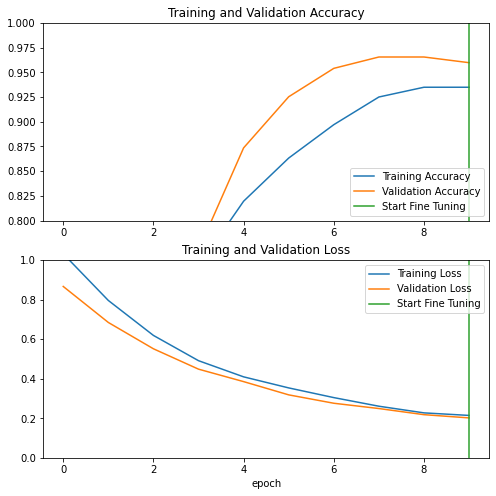

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
loss, accuracy = model.evaluate(test)
loss, accuracy1 = model.evaluate(train)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

38/38 [==============================] - 23s 574ms/step - loss: 0.1984 - accuracy: 0.9662
Test accuracy : 0.984375
Train accuracy : 0.9662273526191711


##   <a name='tunning'>6) Model with fine tunning:</a>

### 6.1) Unfreeze the top layers of the model:


In [26]:
base_model.trainable = True

In [27]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [28]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

### 6.2) Compile the model:


In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

C:\Users\hp\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### 6.3) Training the model:


In [30]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= validation)

Epoch 10/15
38/38 [==============================] - 46s 1s/step - loss: 0.0621 - accuracy: 0.9736 - val_loss: 0.0491 - val_accuracy: 0.9770
Epoch 11/15
38/38 [==============================] - 37s 960ms/step - loss: 0.0236 - accuracy: 0.9901 - val_loss: 0.0261 - val_accuracy: 0.9885
Epoch 12/15
38/38 [==============================] - 39s 1s/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.0217 - val_accuracy: 0.9943
Epoch 13/15
38/38 [==============================] - 39s 1s/step - loss: 0.0139 - accuracy: 0.9959 - val_loss: 0.0325 - val_accuracy: 0.9885
Epoch 14/15
38/38 [==============================] - 37s 968ms/step - loss: 0.0109 - accuracy: 0.9951 - val_loss: 0.0640 - val_accuracy: 0.9770
Epoch 15/15
38/38 [==============================] - 39s 1s/step - loss: 0.0068 - accuracy: 0.9975 - val_loss: 0.0169 - val_accuracy: 0.9943


In [31]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']

### 6.4) Results:


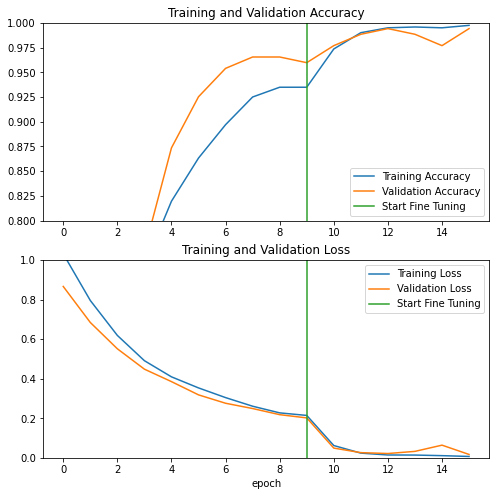

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
loss, accuracy = model.evaluate(test)
loss, accuracy1 = model.evaluate(train)
loss, accuracy2 = model.evaluate(validation)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)
print('Validation accuracy :', accuracy2)

6/6 [==============================] - 3s 451ms/step - loss: 0.0204 - accuracy: 0.9943
Test accuracy : 1.0
Train accuracy : 1.0
Validation accuracy : 0.9942528605461121


In [34]:
model.save('models/mobailnetCat2.h5', overwrite=True)

C:\Users\hp\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
